In [27]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

In [28]:
Data1=pd.read_csv("\\Users\\VISHESH\\OneDrive\\Desktop\\zepto\\Customers.csv")
Data2=pd.read_csv('\\Users\\VISHESH\OneDrive\\Desktop\\zepto\\Products.csv')
Data3=pd.read_csv("\\Users\\VISHESH\OneDrive\\Desktop\\zepto\\Transactions.csv")


<>:2: SyntaxWarning: invalid escape sequence '\O'
<>:3: SyntaxWarning: invalid escape sequence '\O'
<>:2: SyntaxWarning: invalid escape sequence '\O'
<>:3: SyntaxWarning: invalid escape sequence '\O'
C:\Users\VISHESH\AppData\Local\Temp\ipykernel_19136\3949461506.py:2: SyntaxWarning: invalid escape sequence '\O'
  Data2=pd.read_csv('\\Users\\VISHESH\OneDrive\\Desktop\\zepto\\Products.csv')
C:\Users\VISHESH\AppData\Local\Temp\ipykernel_19136\3949461506.py:3: SyntaxWarning: invalid escape sequence '\O'
  Data3=pd.read_csv("\\Users\\VISHESH\OneDrive\\Desktop\\zepto\\Transactions.csv")


In [29]:
merged_data = Data3.merge(Data1, on="CustomerID", how="left")
merged_data = merged_data.merge(Data2, on="ProductID", how="left")

In [30]:
label_encoder = LabelEncoder()
customer_profiles = merged_data.groupby("CustomerID").agg(
    total_spending=("TotalValue", "sum"),
    transaction_count=("TransactionID", "count"),
    avg_transaction_value=("TotalValue", "mean"),
    unique_products=("ProductID", lambda x: x.nunique()),
    region=("Region", "first"),
).reset_index()
customer_profiles = merged_data.groupby("CustomerID").agg(
    total_spending=("TotalValue", "sum"),
    transaction_count=("TransactionID", "count"),
    unique_categories=("Category", lambda x: x.nunique()),
    region=("Region", "first")
).reset_index()
label_encoder = LabelEncoder()
customer_profiles["region_encoded"] = label_encoder.fit_transform(customer_profiles["region"])

features = customer_profiles[["total_spending", "transaction_count", "unique_categories", "region_encoded"]]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

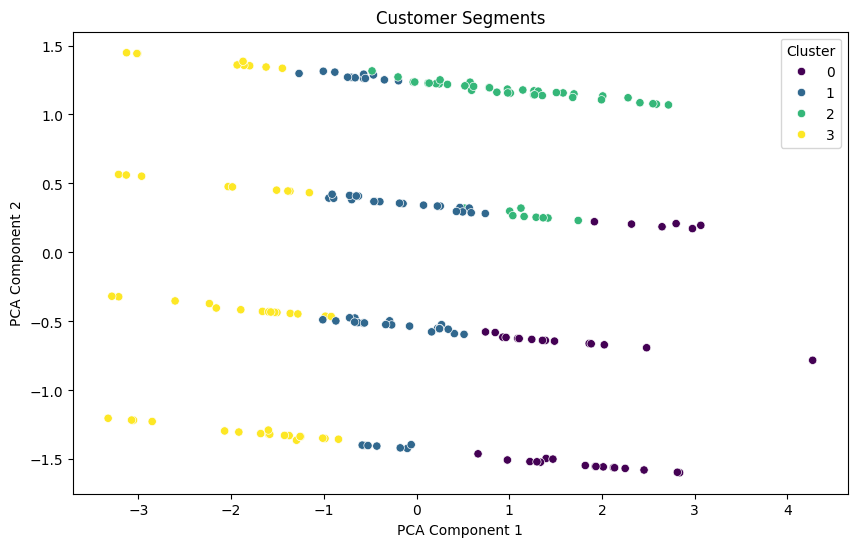

In [31]:
kmeans = KMeans(n_clusters=4, random_state=42)
customer_profiles["cluster"] = kmeans.fit_predict(features_scaled)

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_scaled)
customer_profiles["pca1"] = reduced_features[:, 0]
customer_profiles["pca2"] = reduced_features[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="pca1", y="pca2", hue="cluster", data=customer_profiles, palette="viridis"
)
plt.title("Customer Segments")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Save segmentation results
customer_profiles.to_csv("Vishesh_chavda_Clustering.csv", index=False)

Optimal number of clusters based on DB Index: 9
Davies-Bouldin Index for 9 clusters: 1.0289120567655141


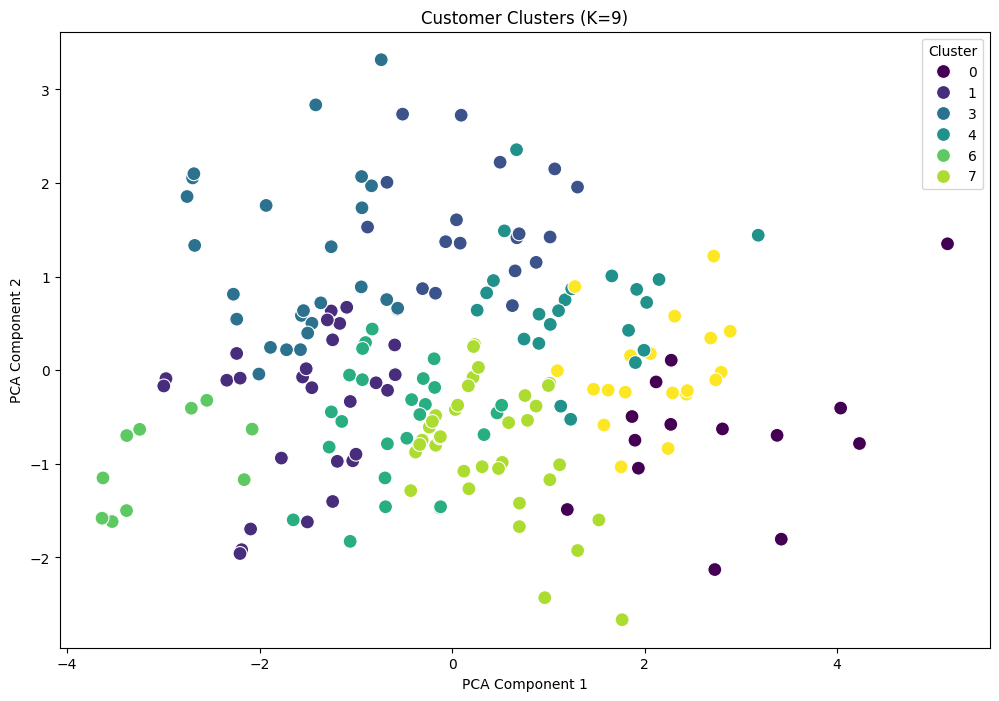

In [ ]:
label_encoder = LabelEncoder()
customer_profiles = merged_data.groupby("CustomerID").agg(
    total_spending=("TotalValue", "sum"),
    transaction_count=("TransactionID", "count"),
    avg_transaction_value=("TotalValue", "mean"),
    unique_products=("ProductID", lambda x: x.nunique()),
    region=("Region", "first"),
).reset_index()
customer_profiles["region_encoded"] = label_encoder.fit_transform(customer_profiles["region"])

# Prepare feature matrix
features = customer_profiles[[
    "total_spending", "transaction_count", "avg_transaction_value", "unique_products", "region_encoded"
]]


scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

db_index_scores = []
for k in range(2, 11):  # Test clusters from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled)
    db_index = davies_bouldin_score(features_scaled, cluster_labels)
    db_index_scores.append((k, db_index))

optimal_k = min(db_index_scores, key=lambda x: x[1])[0]
print(f"Optimal number of clusters based on DB Index: {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_profiles["cluster"] = kmeans.fit_predict(features_scaled)

final_db_index = davies_bouldin_score(features_scaled, customer_profiles["cluster"])
print(f"Davies-Bouldin Index for {optimal_k} clusters: {final_db_index}")

pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_scaled)
customer_profiles["pca1"] = pca_features[:, 0]
customer_profiles["pca2"] = pca_features[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="pca1", y="pca2", hue="cluster", data=customer_profiles, palette="viridis", s=100
)
plt.title(f"Customer Clusters (K={optimal_k})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Save clustering results
customer_profiles.to_csv("Vishesh_chavda_Customer_Clusters.csv", index=False)

# Save DB Index values for all tested cluster sizes
db_index_df = pd.DataFrame(db_index_scores, columns=["Number of Clusters", "DB Index"])
db_index_df.to_csv("Vishesh_Chavda_Clustering_Score.csv", index=False)